In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  OneHotEncoder,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import  LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from prettytable import PrettyTable

<h3> Loading data </h3>

In [2]:
data = pd.read_csv('/kaggle/input/bank-customer-churn-dataset/Bank Customer Churn Prediction.csv')
data.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


<h3> Dataset Info </h3>

In [3]:
print("Shape of Data: ",data.shape, "\n")

print("Data Description")
data.info()

Shape of Data:  (10000, 12) 

Data Description
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


> There are 10,000 rows and 12 columns in the dataset.

In [4]:
data.isnull().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

In [5]:
data.duplicated().sum()

0

<h3> Data Visualization </h3>

In [6]:
# Decode Churn variable 
task_decoder = {"Yes":1, "No":0}

def decode_task(f):
    f["churn"] = f["churn"].astype(str)
    ser = f["churn"]
    for key in task_decoder:
        ser.replace(key, task_decoder[key], inplace=True)
decode_task(data)

data['churn'] = pd.to_numeric(data['churn'], errors='coerce')
data.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [7]:
numerical_columns = data.select_dtypes(include='number').columns.tolist()
categorical_columns = data.select_dtypes(exclude='number').columns.tolist()
numerical_columns.remove('churn')
print("Numerical Features:", numerical_columns , "\n")
print("Categorical Features", categorical_columns)

Numerical Features: ['customer_id', 'credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary'] 

Categorical Features ['country', 'gender']


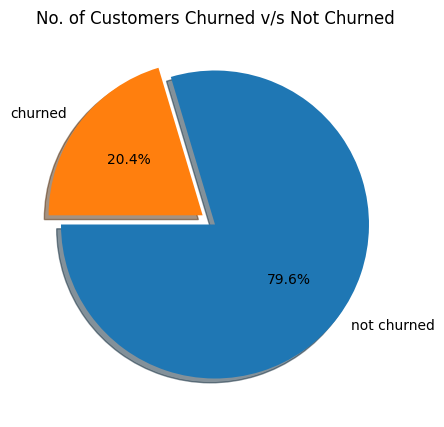

In [8]:
class_counts = data['churn'].value_counts()
fig = plt.figure(figsize=(5,5)) 
plt.pie(class_counts, labels=['not churned','churned'],explode=(0,0.1),shadow=True, autopct="%1.1f%%", startangle=180)
plt.title('No. of Customers Churned v/s Not Churned')
plt.show()

> **Insights:**
> - Many people tend **`not to churn`**.
> - Our data is **`imbalanced`**

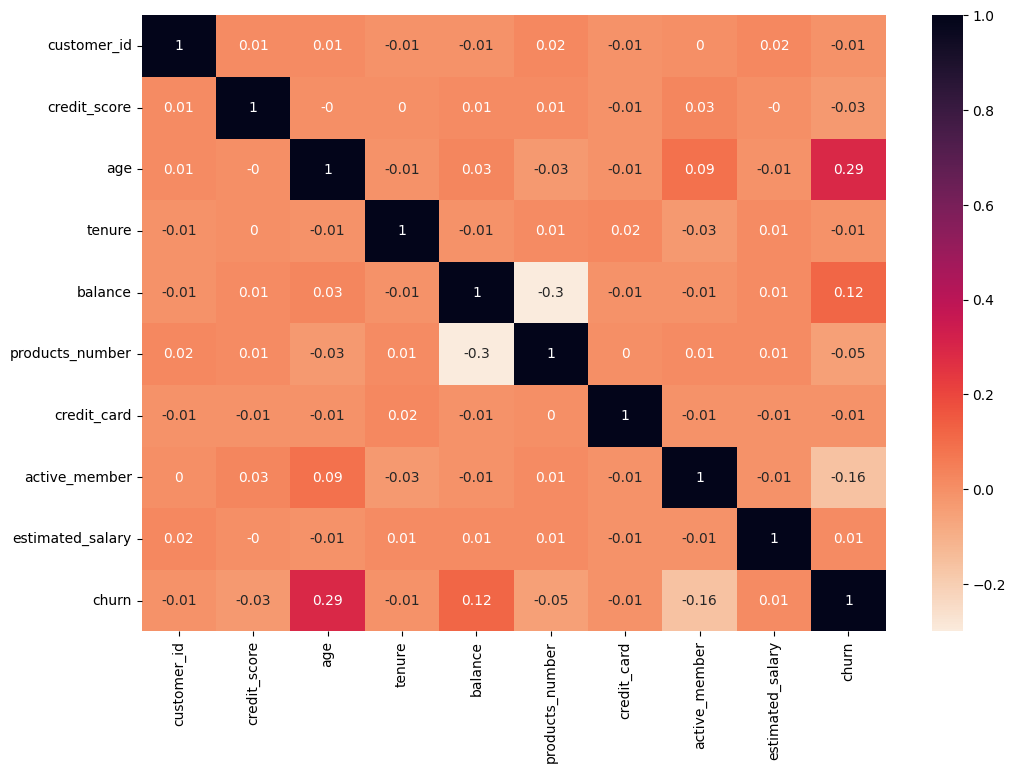

In [9]:
c_map=sns.color_palette("rocket_r", as_cmap=True)
correlation = data.corr(numeric_only=True).round(2)
plt.figure(figsize = (12,8))
sns.heatmap(correlation, annot = True, cmap = c_map)
plt.show()

In [10]:
abs(correlation['churn']).sort_values(ascending=False)

churn               1.00
age                 0.29
active_member       0.16
balance             0.12
products_number     0.05
credit_score        0.03
customer_id         0.01
tenure              0.01
credit_card         0.01
estimated_salary    0.01
Name: churn, dtype: float64

> **age**, **active_member**, **balance** show a relatively stronger correlation with the outcome of churn

In [11]:
legend_labels = {1: 'Yes', 0: 'No'}

9


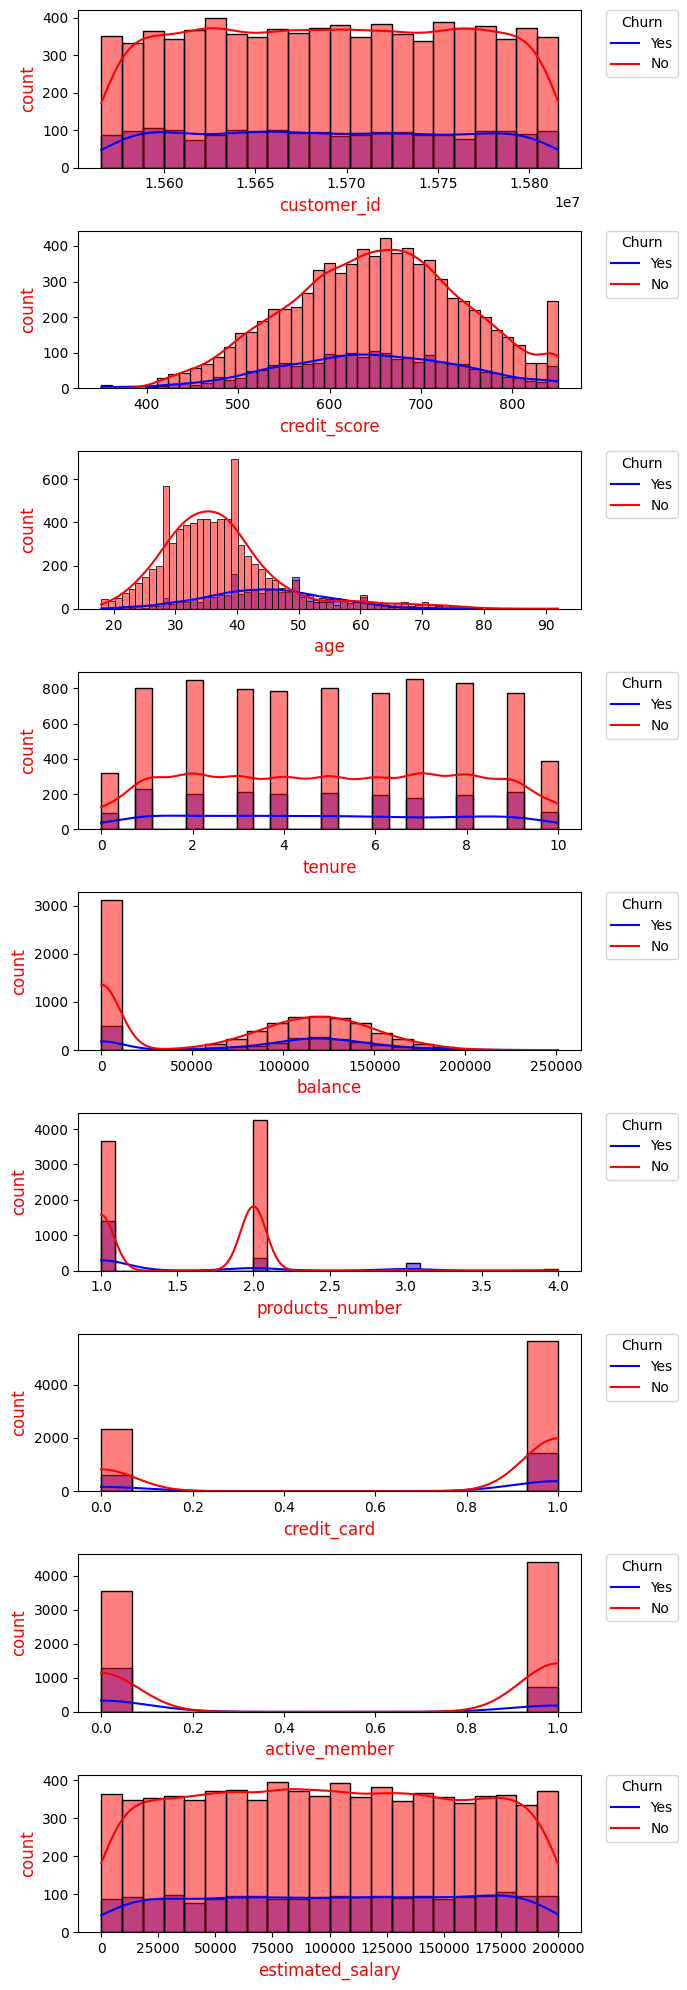

In [12]:
colors = ["red", "green", "blue", "orange"]

num_cols = len(numerical_columns)
print(num_cols)
plt.figure(figsize=(7, 20))

for i, col in enumerate(numerical_columns, start=1):
    plt.subplot(num_cols, 1, i)
    sns.histplot(data=data, x=col, hue='churn', kde=True, palette=[colors[0], colors[2]])
    plt.legend(title='Churn', labels=[legend_labels[x] for x in data['churn'].unique()], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    plt.xlabel(col, fontsize=12, color=colors[0])
    plt.ylabel('count', fontsize=12, color=colors[0])

plt.tight_layout()
plt.show()

/tmp/ipykernel_19/1738232443.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='tenure', y='count', data=churned, ci=None)


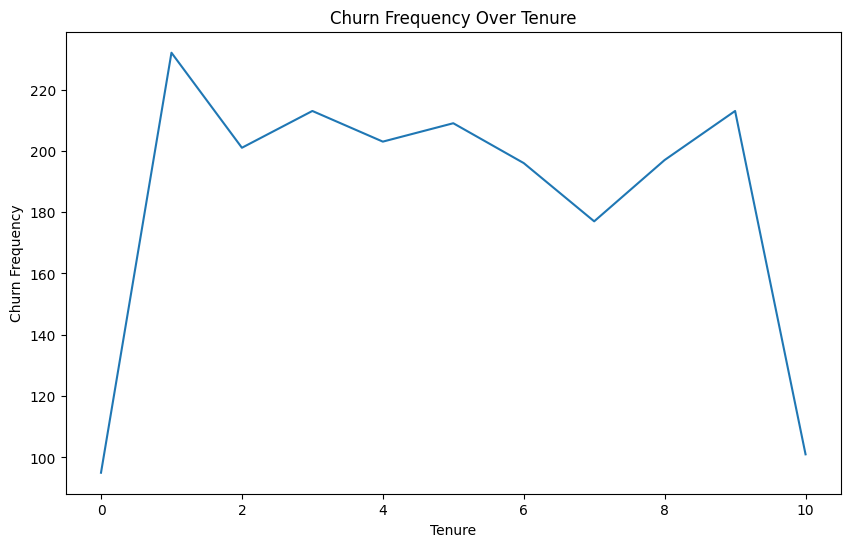

In [13]:
tenure_churn_count = data.groupby(['tenure', 'churn']).size().reset_index(name='count')

# Filter churn occurrences to plot only churned instances
churned = tenure_churn_count[tenure_churn_count['churn'] == 1]

# Plotting the line chart
plt.figure(figsize=(10, 6))
sns.lineplot(x='tenure', y='count', data=churned, ci=None)
plt.xlabel('Tenure')
plt.ylabel('Churn Frequency')
plt.title('Churn Frequency Over Tenure')
plt.show()

> **Credit Score**
> - Most people have a credit score between 600 and 700.

> **Age**
> - Most non-churners are 30-40 years old, while most churners are 40-60 years old.

> **Tenure**
> - Most churners have a tenure of 1 year.
> - Only a few customers have a tenure of 0 or 10 years.
> - From 2 to 7 years Churn count is gradually decrease
> - After 7 year to 9 years a hype of churn created due to which count of customer decrease so after 9 years churn frequency is down rapidly.

> **Balance**
> - There are many people who have no bank balance

> **Product Number**
> - Most customers have only 1 or 2 products.
> - Most of the non-churners have 2 products.
> - Most of the churners have 1 product.
> - Customers having 3,4 products are mostly churners.

> **Credit Card and Active Member**
> - Most churners have credit cards but are not active members




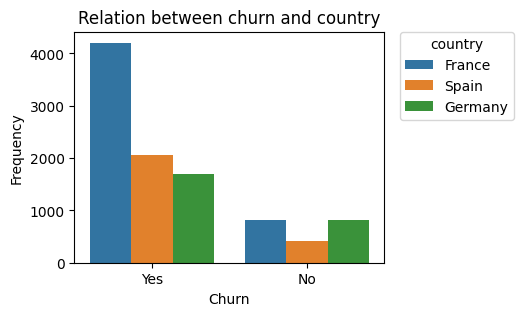

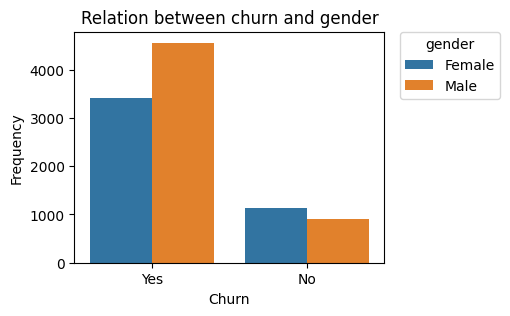

In [14]:
for col in categorical_columns:
    plt.figure(figsize=(4, 3))  # Adjust figure size if needed
    c = sns.countplot(x='churn', hue=col, data=data)
    c.set_xticklabels(['Yes' if x==1 else 'No' for x in data['churn'].unique()])
    plt.legend(title=col,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    plt.title(f'Relation between churn and {col}')
    plt.xlabel("Churn")
    plt.ylabel('Frequency')
    plt.show()

> - France has the highest number of churners
> - Spain has relatively few churners.
> - Female churners > Male churners.

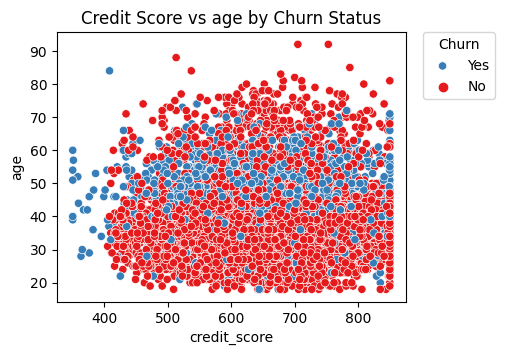

In [15]:
plt.figure(figsize=(4.5, 3.5))
sns.scatterplot(x='credit_score', y='age', hue='churn', data=data, palette='Set1')
plt.legend(title='Churn', labels=[legend_labels[x] for x in data['churn'].unique()], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.title('Credit Score vs age by Churn Status')
plt.xlabel('credit_score')
plt.ylabel('age')
plt.show()

> - High Credit Score with below age 50 are less likely to **`Churn`**
> - Whose Credit Score is high but age is above 50 are more likely to **`Churn`**

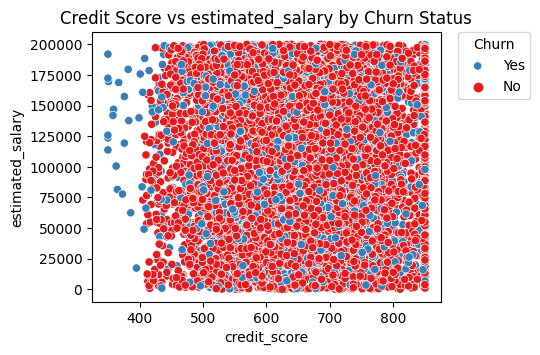

In [16]:
plt.figure(figsize=(4.5, 3.5))
sns.scatterplot(x='credit_score', y='estimated_salary', hue='churn', data=data, palette='Set1')
plt.legend(title='Churn', labels=[legend_labels[x] for x in data['churn'].unique()], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.title('Credit Score vs estimated_salary by Churn Status')
plt.xlabel('credit_score')
plt.ylabel('estimated_salary')
plt.show()

> - Customers with a credit score < 400 are mostly churners

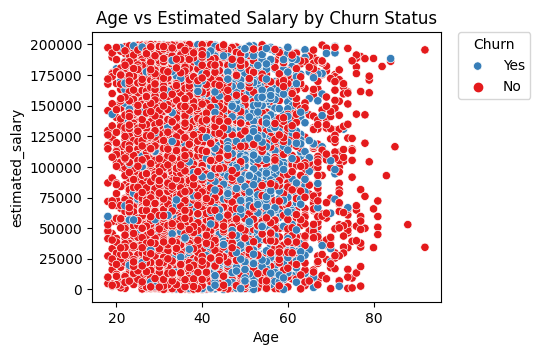

In [17]:
plt.figure(figsize=(4.5, 3.5))
sns.scatterplot(x='age', y='estimated_salary', hue='churn', data=data, palette='Set1')
plt.legend(title='Churn', labels=[legend_labels[x] for x in data['churn'].unique()], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.title('Age vs Estimated Salary by Churn Status')
plt.xlabel('Age')
plt.ylabel('estimated_salary')
plt.show()

> - Most churners lie within the age group of 40-60 years

<h3> Apply ML Models </h3>

In [18]:
X = data.drop('churn', axis=1)
y = data['churn']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
print(f'X_train data size {X_train.shape}')
print(f'y_train data size {y_train.shape} \n')

print(f'X_test data size {X_test.shape}')
print(f'y_test data size {y_test.shape} \n')

X_train data size (8000, 11)
y_train data size (8000,) 

X_test data size (2000, 11)
y_test data size (2000,) 



In [21]:
encoder = OneHotEncoder()

**Imputing**

We will make imputer for **categorical** columns with the **`mode`** and for **numerical** columns with the **`median`**

In [22]:
cat_imputer = SimpleImputer(strategy = "most_frequent")
num_imputer = SimpleImputer(strategy = "median")

In [23]:
cat = Pipeline([
    ("cat_imputer", cat_imputer),
    ("end", encoder)
])

num = Pipeline([
    ("num_imputer", num_imputer),
    ("scaler", StandardScaler()),
])

In [24]:
cleaning = ColumnTransformer([
    ("num", num, numerical_columns),
    ("cat", cat, categorical_columns),
], remainder = "passthrough")
X_train_final = cleaning.fit_transform(X_train)
X_test_final = cleaning.fit_transform(X_test)

print('Training Dataset',X_train_final.shape)
print('Testing Dataset', X_test_final.shape)

Training Dataset (8000, 14)
Testing Dataset (2000, 14)


**SMOTE**

Using SMOTE to handle data imbalance

In [25]:
# oversampling of minority class with smote
print("count of the classes before oversampling: ",dict(y_train.value_counts()))
sm = SMOTE(sampling_strategy ='minority')
x_train_os,y_train_os = sm.fit_resample(X_train_final,y_train)
print("count of the classes after oversampling: ",dict(y_train_os.value_counts()))

print(y_train_os.value_counts())

count of the classes before oversampling:  {0: 6356, 1: 1644}
count of the classes after oversampling:  {0: 6356, 1: 6356}
churn
0    6356
1    6356
Name: count, dtype: int64


In [26]:
models_data = list()
best_model = list()

In [27]:
# create class to automate a lot of work that we are going to do.
class Classifier:
    def __init__(self, model, x, y,x_test,y_test):
        self.x = x
        self.y = y
        self.x_test = x_test
        self.y_test = y_test
        self.model = model
    
    def algorithm(self):
        parameters = {'C' : np.logspace(-4, 4, 20)}
        parameters_DT = {'max_depth': [None, 5, 10, 20,30,50], 'min_samples_split': [2, 5, 10,15,20]}
        
        if self.model.__class__.__name__ == 'DecisionTreeClassifier':
            grid_dt = GridSearchCV(estimator=self.model, param_grid=parameters_DT,cv=5,scoring='accuracy',return_train_score=True,verbose=1)
            grid_dt.fit(self.x,self.y)
            print()
            print(self.model.__class__.__name__)
            print("-----"*20)
            print("Best Parameter", grid_dt.best_params_)
            cv_result = pd.DataFrame(grid_dt.cv_results_)

            plt.scatter(cv_result['param_max_depth'], cv_result['mean_train_score'])
            plt.plot(cv_result['param_max_depth'], cv_result['mean_train_score'], label='Train')

            plt.scatter(cv_result['param_max_depth'], cv_result['mean_test_score'])
            plt.plot(cv_result['param_max_depth'], cv_result['mean_test_score'], label="CV")

            plt.title('Hyperparameter vs accuracy')
            plt.legend()
            plt.xlabel('max_depth')
            plt.ylabel('Accuracy')

            plt.show()
            
            best_estimator_DT = grid_dt.best_estimator_
            self.optimal_estimator(best_estimator_DT)
            
        else:
            grid = GridSearchCV(estimator=self.model, param_grid=parameters,cv=5,scoring='accuracy',return_train_score=True,verbose=1)
            grid.fit(self.x,self.y)
            print()
            print(self.model.__class__.__name__)
            print("-----"*20)
            print("Best Parameter", grid.best_params_)
            cv_result = pd.DataFrame(grid.cv_results_)
            plt.scatter(cv_result['param_C'],cv_result['mean_train_score'])
            plt.plot(cv_result['param_C'],cv_result['mean_train_score'],label='Train')

            plt.scatter(cv_result['param_C'],cv_result['mean_test_score'])
            plt.plot(cv_result['param_C'],cv_result['mean_test_score'],label="CV")

            plt.title('Hyperparameter vs accuracy')
            plt.legend()
            plt.xlabel('C')
            plt.ylabel('Accuracy')
            plt.show()
            
            best_estimator = grid.best_estimator_
            self.optimal_estimator(best_estimator)
            
    def optimal_estimator(self,best_estimator):
        best_estimator.fit(self.x,self.y)
        best_model.append({'best_model':best_estimator})
        
        result = []
        y_pred_tr = best_estimator.predict(self.x)
        result.append(round(accuracy_score(self.y,y_pred_tr),2))
        print('Train accuracy: ',result[0])

        error = 1 - result[0]
        result.append(round(error,2))
        print("Training Error: ", result[1],'\n')

        y_pred_test = best_estimator.predict(self.x_test)
        result.append(round(accuracy_score(self.y_test,y_pred_test),2))
        print('Test accuracy: ',result[2])

        error = 1 - result[2]
        result.append(round(error,2))
        print("Testing Error: ", result[3],'\n')
        
        recall = recall_score(y_test,y_pred_test)
        result.append(round(recall,2))
        print("Recall Score: ",result[4])

        f_measure = f1_score(self.y_test, y_pred_test)
        result.append(round(f_measure,2))
        print("F-measure: ", result[5])

        models_data.append({'Model':self.model.__class__.__name__,'Train accuracy':result[0], 'Test accuracy':result[2],'F-measure': result[5],
                            'Recall Score': result[4]})
        # Show the confusion matrix
        cf_matrix = metrics.confusion_matrix(self.y_test,y_pred_test)
        group_names = ['True Neg','False Pos','False Neg','True Pos']
        group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        plt.figure(figsize=(6,5))
        ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap=c_map)
        ax.set_xlabel('\nPredicted Values')
        ax.set_ylabel('Actual Values ')
        ax.xaxis.set_ticklabels(['False','True'])
        ax.yaxis.set_ticklabels(['False','True'])
        plt.show()
        

In [28]:
models = [
    LogisticRegression(random_state = 42),
    DecisionTreeClassifier(random_state = 42),
    SVC(random_state = 42),
]

Fitting 5 folds for each of 20 candidates, totalling 100 fits

LogisticRegression
----------------------------------------------------------------------------------------------------
Best Parameter {'C': 0.23357214690901212}


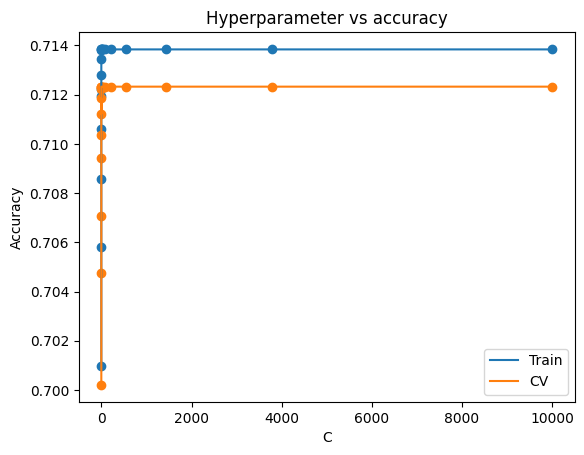

Train accuracy:  0.71
Training Error:  0.29 

Test accuracy:  0.73
Testing Error:  0.27 

Recall Score:  0.73
F-measure:  0.52


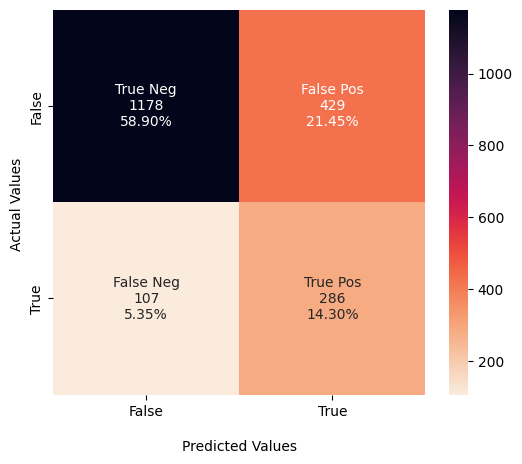

Fitting 5 folds for each of 30 candidates, totalling 150 fits

DecisionTreeClassifier
----------------------------------------------------------------------------------------------------
Best Parameter {'max_depth': None, 'min_samples_split': 2}


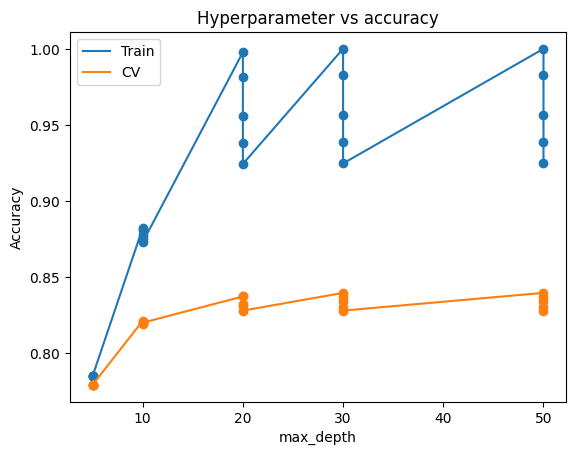

Train accuracy:  1.0
Training Error:  0.0 

Test accuracy:  0.57
Testing Error:  0.43 

Recall Score:  0.73
F-measure:  0.4


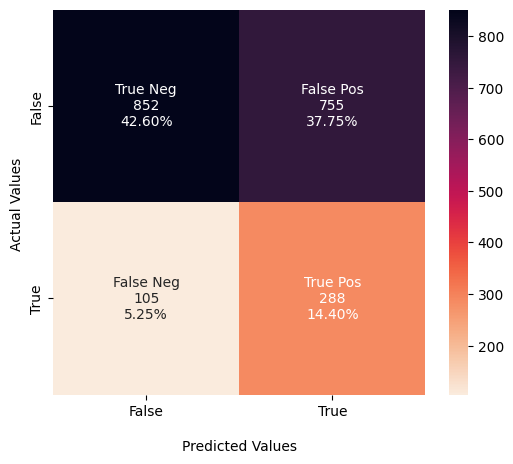

Fitting 5 folds for each of 20 candidates, totalling 100 fits

SVC
----------------------------------------------------------------------------------------------------
Best Parameter {'C': 545.5594781168514}


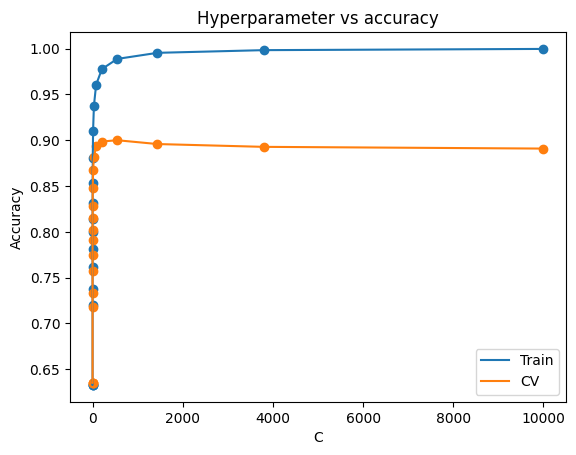

Train accuracy:  0.99
Training Error:  0.01 

Test accuracy:  0.79
Testing Error:  0.21 

Recall Score:  0.53
F-measure:  0.5


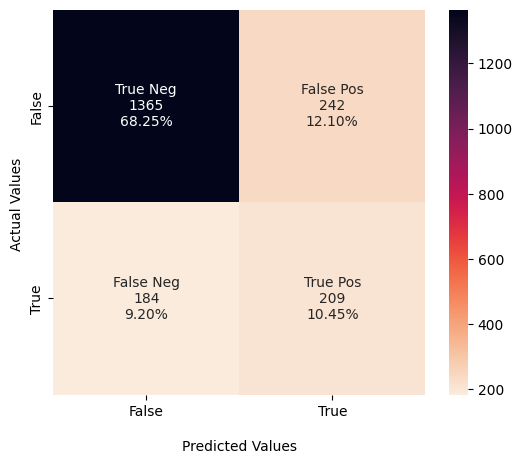

In [29]:
for model in models:
    clf = Classifier(model,x_train_os,y_train_os, X_test_final, y_test)
    clf.algorithm()

<h4> Random Forest </h4>

Fitting 5 folds for each of 20 candidates, totalling 100 fits
----------------------------------------------------------------------------------------------------


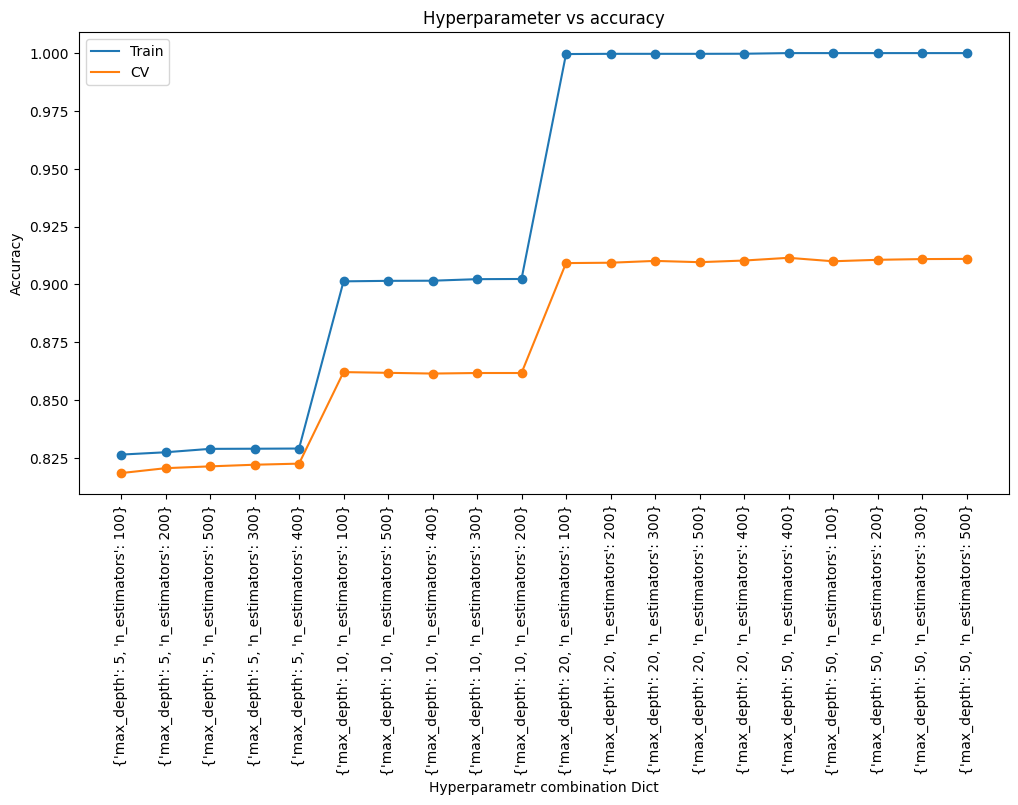

In [30]:
# Grid Search To Get Best Hyperparameters
parameters = {'max_depth':[5,10,20,50], 'n_estimators': [100,200,300,400,500]}
clf_rf = RandomForestClassifier(random_state=43)      
grid = GridSearchCV(estimator=clf_rf, param_grid=parameters,scoring='accuracy',return_train_score=True,verbose=1)
grid.fit(x_train_os,y_train_os)

print("-----"*20)
cv_result = pd.DataFrame(grid.cv_results_).sort_values(by='mean_train_score',ascending=True)
params = list(cv_result['params'].astype(str))

plt.figure(figsize=(12,6))
plt.scatter(params,cv_result['mean_train_score'])
plt.plot(params,cv_result['mean_train_score'],label='Train')
plt.scatter(params,cv_result['mean_test_score'])
plt.plot(params,cv_result['mean_test_score'],label="CV")
plt.title('Hyperparameter vs accuracy')
plt.legend()
plt.xlabel('Hyperparametr combination Dict')
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.show()

In [31]:
best_estimator = grid.best_estimator_
print(best_estimator)

RandomForestClassifier(max_depth=50, n_estimators=400, random_state=43)


In [32]:
# Training the model again using the optimal parameters discovered
clf_rf = RandomForestClassifier(max_depth=10,n_estimators=300, random_state=43)
clf_rf.fit(x_train_os,y_train_os)

result = []
y_pred_tr = clf_rf.predict(x_train_os)
result.append(round(accuracy_score(y_train_os,y_pred_tr),2))
print('Train accuracy: ',result[0])

error = 1 - result[0]
result.append(round(error,2))
print("Training Error: ", result[1],'\n')

y_pred_test = clf_rf.predict(X_test_final)
result.append(round(accuracy_score(y_test,y_pred_test),2))
print('Test accuracy: ',result[2])

error = 1 - result[2]
result.append(round(error,2))
print("Testing Error: ", result[3],'\n')
        
recall = recall_score(y_test,y_pred_test)
result.append(round(recall,2))
print("Recall Score: ",result[4])

f_measure = f1_score(y_test, y_pred_test)
result.append(round(f_measure,2))
print("F-measure: ", result[5])

models_data.append({'Model':'RandomForestClassifier','Train accuracy':result[0], 'Test accuracy':result[2],'F-measure': result[5],
                            'Recall Score': result[4]})

Train accuracy:  0.9
Training Error:  0.1 

Test accuracy:  0.8
Testing Error:  0.2 

Recall Score:  0.74
F-measure:  0.59


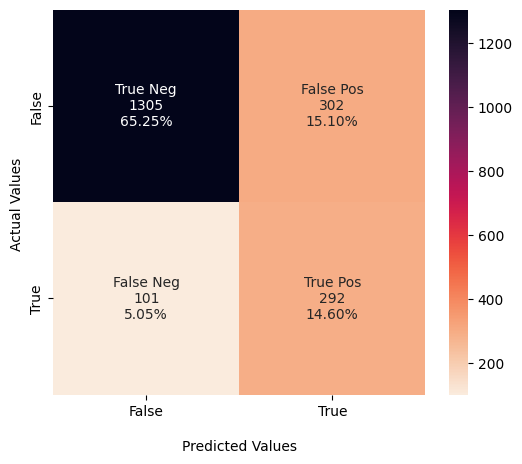

In [33]:
cf_matrix = metrics.confusion_matrix(y_test,y_pred_test)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(6,5))
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap=c_map)
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

In [34]:
models_data

[{'Model': 'LogisticRegression',
  'Train accuracy': 0.71,
  'Test accuracy': 0.73,
  'F-measure': 0.52,
  'Recall Score': 0.73},
 {'Model': 'DecisionTreeClassifier',
  'Train accuracy': 1.0,
  'Test accuracy': 0.57,
  'F-measure': 0.4,
  'Recall Score': 0.73},
 {'Model': 'SVC',
  'Train accuracy': 0.99,
  'Test accuracy': 0.79,
  'F-measure': 0.5,
  'Recall Score': 0.53},
 {'Model': 'RandomForestClassifier',
  'Train accuracy': 0.9,
  'Test accuracy': 0.8,
  'F-measure': 0.59,
  'Recall Score': 0.74}]

In [35]:
df = pd.DataFrame(models_data)
df.head()

,Model,Train accuracy,Test accuracy,F-measure,Recall Score
0,LogisticRegression,0.71,0.73,0.52,0.73
1,DecisionTreeClassifier,1.00,0.57,0.40,0.73
2,SVC,0.99,0.79,0.50,0.53
3,RandomForestClassifier,0.90,0.80,0.59,0.74


> **Model Selection**

> Based on a holistic assessment of the performance metrics, the Random Forest model emerges as
the frontrunner. While it presented a marginally lower training accuracy compared to SVM and
Decision Tree, its balanced F-measure and high recall score substantiate its superiority in predicting
customer churn within this dataset.Maximizing recall reduces the risk of overlooking potential churners,
optimizing customer retention efforts. Therefore, the Random Forest model is selected as the optimal
choice for this prediction task